# The Computational Image of the City: Nodes, Paths and Districts

In [1]:
import osmnx as ox, networkx as nx, matplotlib.cm as cm, pandas as pd, numpy as np
import community
import matplotlib.pyplot as plt
from importlib import reload
import geopandas as gpd
import functools
import time
%matplotlib inline

pd.set_option('precision', 5)
pd.options.display.float_format = '{:20.2f}'.format
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.mode.chained_assignment = None

import street_network_functions as snf
import utilities as uf

C:\Users\g_filo01\AppData\Local\Continuum\anaconda3\lib\site-packages\pysal\__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysalnext` package. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)


In [2]:
reload(snf)

<module 'street_network_functions' from 'C:\\Users\\g_filo01\\sciebo\\scripts\\Image of the City\\street_network_functions.py'>

In [3]:
#initialise path, names, etc.

city_name = 'London'
folder_ouptut ='Outputs/'+city_name+'/'
epsg = 27700
crs = {'init': 'epsg:27700', 'no_defs': True}

# city_name = 'Boston'
# folder_output ='Outputs/'+city_name+'/'
# epsg = 26986
# crs = {'init': 'epsg:26986', 'no_defs': True}

# city_name = 'Muenster'
# folder_ouptut ='Outputs/'+city_name+'/'
# epsg = 25832
# crs = {'init': 'epsg:25832', 'no_defs': True}

## Downloading the data by place or Loading shapefile

1 or 2 street networks (SN) may be needed when the case study is a particular urban area (UA).

#### Option 1 ------------
Only one graph is used (*graph_A*): It includes the SN of UA and its surroundings (e.g. buffer of 2000 mt) and it is used for computing centrality measures as well as for districts identification. Paths, nodes and districts are extracted from *graph_A* by clipping them from the polygon representing UA extension. A large network is empolyed so as to prevent the edge-effect when computing centrality measures.

#### Option 2 ------------
Two graphs are used: *graph_A* as above, plus a second one, *graph_B* even more extended than the first, for a more precise districts extraction. Paths and nodes are extracted from *graph_A*, districts from *graph_B*, by clipping them from the polygon representing UA extension.

In [4]:
# choose the method and specify how the graph is obtained

option_1 = True
option_2 = False

download = True
shapeFiles = False

In [6]:
# provide files' directories and loading the data

if (shapeFiles == True):
    
    if (city_name == 'Boston'):
        directory_polygon = 'C:/Users/g_filo01/sciebo/GIS Data/Boston/city_center.shp'
        directory_graph_A = 'C:/Users/g_filo01/sciebo/GIS Data/Boston/Street_Network/boston_sn_26986_clipped_4000.shp'  
        directory_graph_B = 'C:/Users/g_filo01/sciebo/GIS Data/Boston/Street_Network/boston_sn_26986_clipped_8000_noHW.shp'
    
    elif (city_name == 'London'):
        directory_polygon = 'C:/Users/g_filo01/sciebo/GIS Data/London/Congestion_area_polygon/Polygon.shp'
        directory_graph_B = 'C:/Users/g_filo01/sciebo/GIS Data/London/Meridian/Meridian_simplified.shp'
    
    if (option_1 == True):
        nodes_small, edges_small = snf.get_fromSHP(directory_graphA, epsg, crs, area = None)
        polygon_clip = gpd.read_file(directory_polygon)
    
    elif (option_2 == True):
        nodes_small, edges_small = snf.get_fromSHP(directory_graphA, epsg, crs, simplify = True, area = None)
        nodes_large, edges_large =  snf.get_fromSHP(directory_graph_B, epsg, crs, area = None)
        polygon_clip = gpd.read_file(directory_polygon)

Choose between the following methods:
* *OSMplace*, provide an OSM place name (e.g. City).
* *OSMpolygon*, provide an OSM polygon (relation) name.
* *distance_from_address*, provide a precise address.
* *shapefilePolygon*, provide directory of a .shp file of the area.

In [13]:
# placeMuenster = 'Münster-Mitte'
placeLondon = 'Temple Place, London, UK'
method_A = 'distance_from_address'
method_B = 'shapefilePolygon' 

if (download == True):
    
    if (option_1 == True):
        #graph_A  
        nodes_small, edges_small = snf.get_fromOSM(method_A, placeLondon, 'walk', epsg, distance = 4000)
#         polygon_clip = gpd.read_file(directory_polygon)
#         nodes_small, edges_small = snf.get_fromOSM(method_A, placeMuenster, 'walk', epsg)
        print("done - Option 1")
        
    
    elif (option_2 == True):      
        #graph_A
        method_A = 'distance_from_address' 
        place_A = 'Temple Place, London, UK'
        nodes_small, edges_small = snf.get_fromOSM(method_A, place_A, 'walk', epsg, distance = 4000)
        
        # graph_B
        method_B = 'shapefilePolygon' 
        place_B = 'Greater London (175342)'
        nodes_large, edges_large = snf.get_fromOSM(method_B, place_B, 'walk', epsg)
        
        print("done - Option 2")

done - Option 1


## Cleaning and simplyfing the Street Network - gdf

At the end of the previous section two files are obtained: nodes and edges (vertexes, or links). Below, before creating the actual graph, the two datasets are cleaned, simplified and corrected.

Cleaning functions handle:
* Duplicate geometries (nodes, edges).
* Pseudo-nodes.
* Dead-ends (optional).

In [14]:
nodes_small, edges_small = snf.reset_index_gdf(nodes_small, edges_small)
nodes_small, edges_small = snf.clean_network(nodes_small, edges_small, dead_ends = True)
nodes_small, edges_small = snf.correct_edges(nodes_small, edges_small)

possible double edges 423
possible double edges 261
possible double edges 73
possible double edges 24
possible double edges 5
possible double edges 3
possible double edges 1
Correcting edges coordinates..
Done
Done after  7  cycles
Correcting edges coordinates..
Done


In [ ]:
# cleaning and simplifying large network as well
if Option_2 == True:
    nodes_large, edges_large = snf.reset_index_gdf(nodes_large, edges_large)
    nodes_large, edges_large = snf.clean_network(nodes_large, edges_large, dead_ends = True)
    nodes_small, edges_small = snf.correct_edges(nodes_small, edges_small)

## Indexes computation - Nodes

On the primal graph representation of the street network, the following centrality measures are computed on nodes, on the basis of Euclidean distance:
* Betweenness centrality.
* Straightness centrality (see [Crucitti et al. 2006](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.73.036125)).
* Reach centrality (readataped from [Sevtsuk & Mekonnen 2012](https://www.sutd.edu.sg/cmsresource/idc/papers/2012_Urban_Network_Analysis_A%20New%20Toolbox_for_ArcGIS.pdf)) - it measures the importance of a node based on the number of services (e.g. commercial activities) reachable by that node (for instance within a buffer).
* Local betweenness centrality (slow).

The first measure (*Bc*) is here used to identify Lynchian nodes.

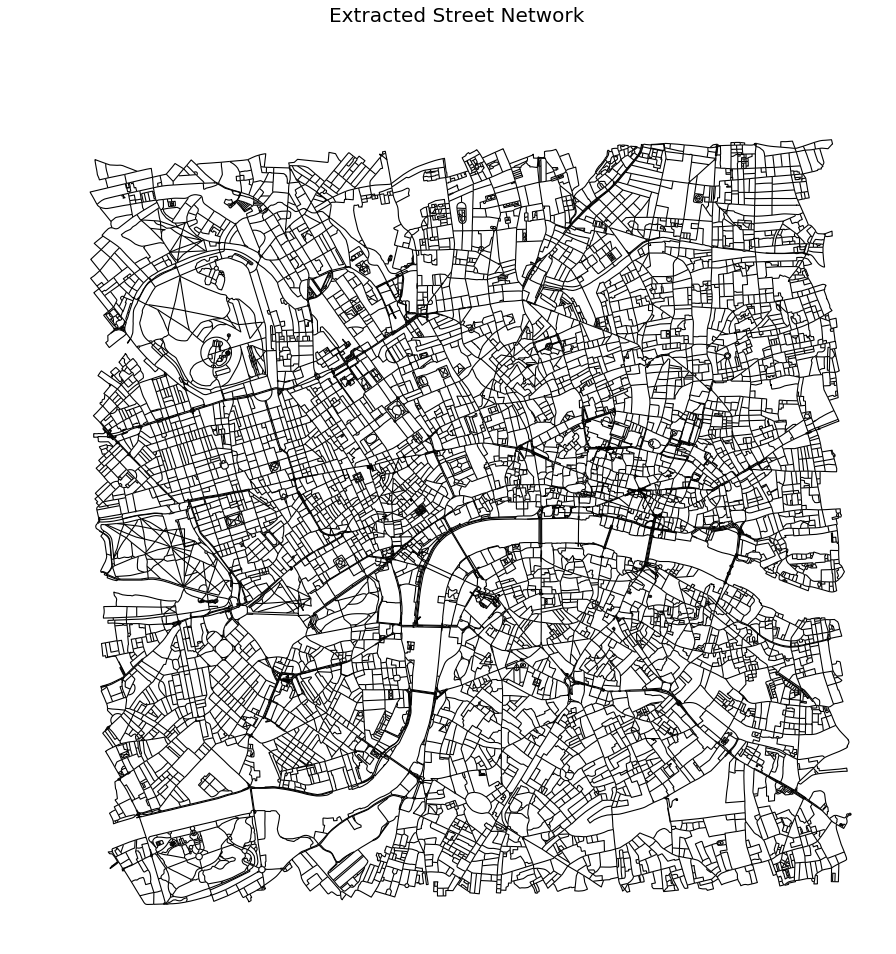

In [15]:
uf.plot_lines(edges_small, bb = False, f = 15, title = 'Extracted Street Network')

In [58]:
# obtaining graph from the two geodataframes
if 'key' in edges_small.columns: edges_small = edges_small[edges_small.key == 0]
NGs = snf.graph_fromGDF(nodes_small, edges_small, 'nodeID')

### Centrality measures

In [59]:
# betweenness centrality
Bc = nx.betweenness_centrality(NGs, k = None, weight = 'length', normalized = False)

In [ ]:
# straightness centrality
# Sc = snf.straightness_centrality(NGs, weight = 'length', normalized=False)

In [60]:
# reach centrality pre-computation, in relation to Point of Interests or any other point-geodataframes 
services = (gpd.read_file('C:/Users/g_filo01/sciebo/GIS Data/London/OS OpenMap Local/London_POI.shp')).to_crs(epsg=epsg)

# using a 50 mt buffer
NGs = snf.weight_nodes(nodes_small, services, NGs, buffer = 50, name = 'services')
      
# Reach Centrality
Rc400 = snf.reach_centrality(NGs, weight = 'length', radius = 400, attribute = 'services') 
Rc600 = snf.reach_centrality(NGs, weight = 'length', radius = 600, attribute = 'services')

In [ ]:
# Local Betweenness Centrality
Bc600 = snf.local_betweenness_centrality(NGs, weight = 'length', radius = 400) 
Bc400 = snf.local_betweenness_centrality(NGs, weight = 'length', radius = 600)

In [ ]:
# saving the attributes in a geodataframe

col = [Bc, Bc400, Bc600, Rc400, Rc600]
names = ['Bc', 'Bc400', 'Bc600','Rc400', 'Rc600']
nodes_df = uf.dict_to_df(col, names)
nodes = pd.merge(nodes_small, nodes_df, left_on= "nodeID", right_index = True, how = 'left')

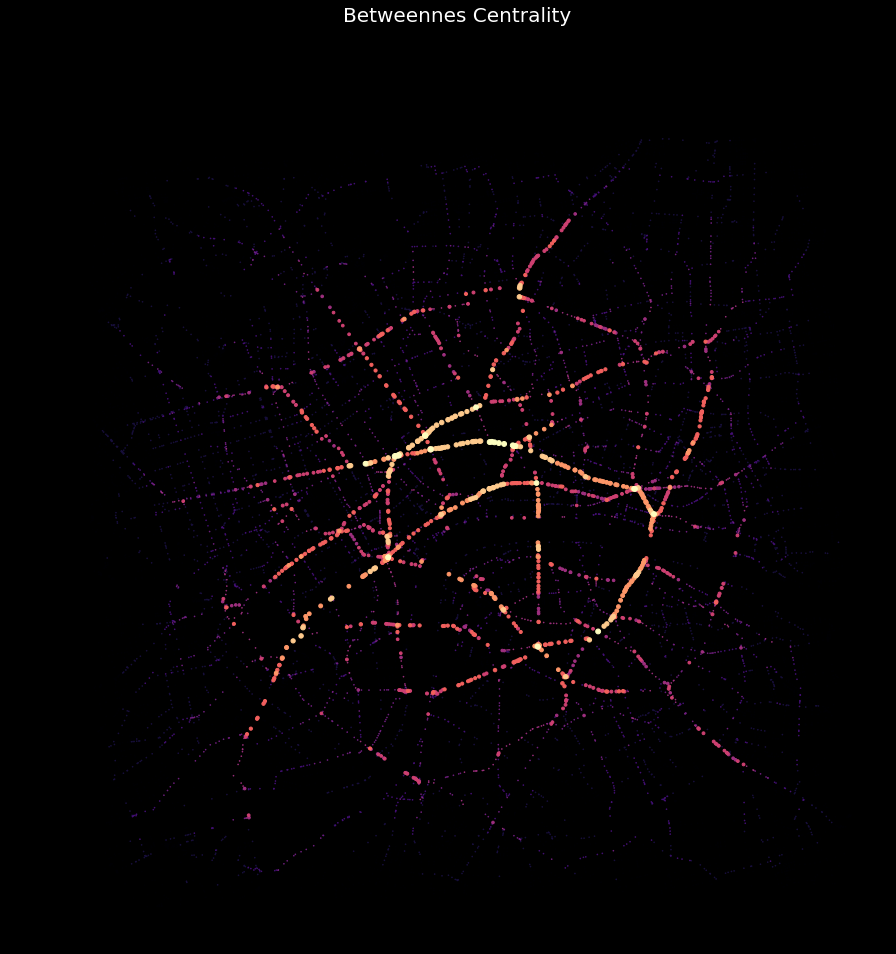

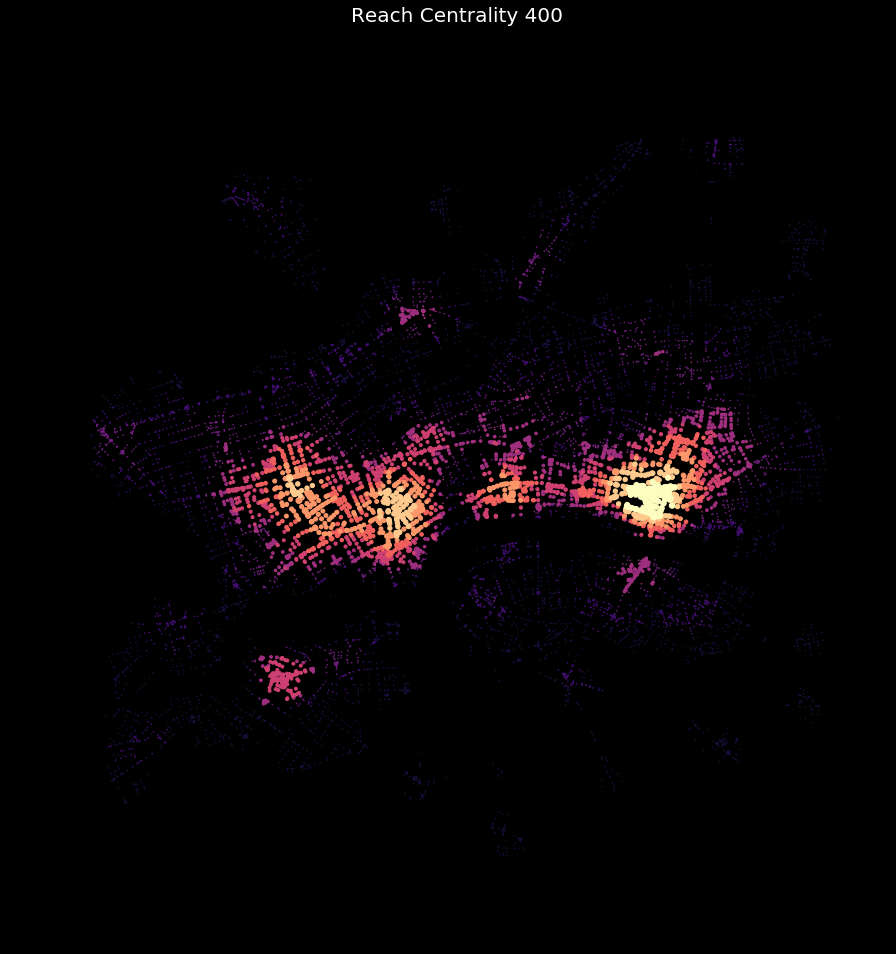

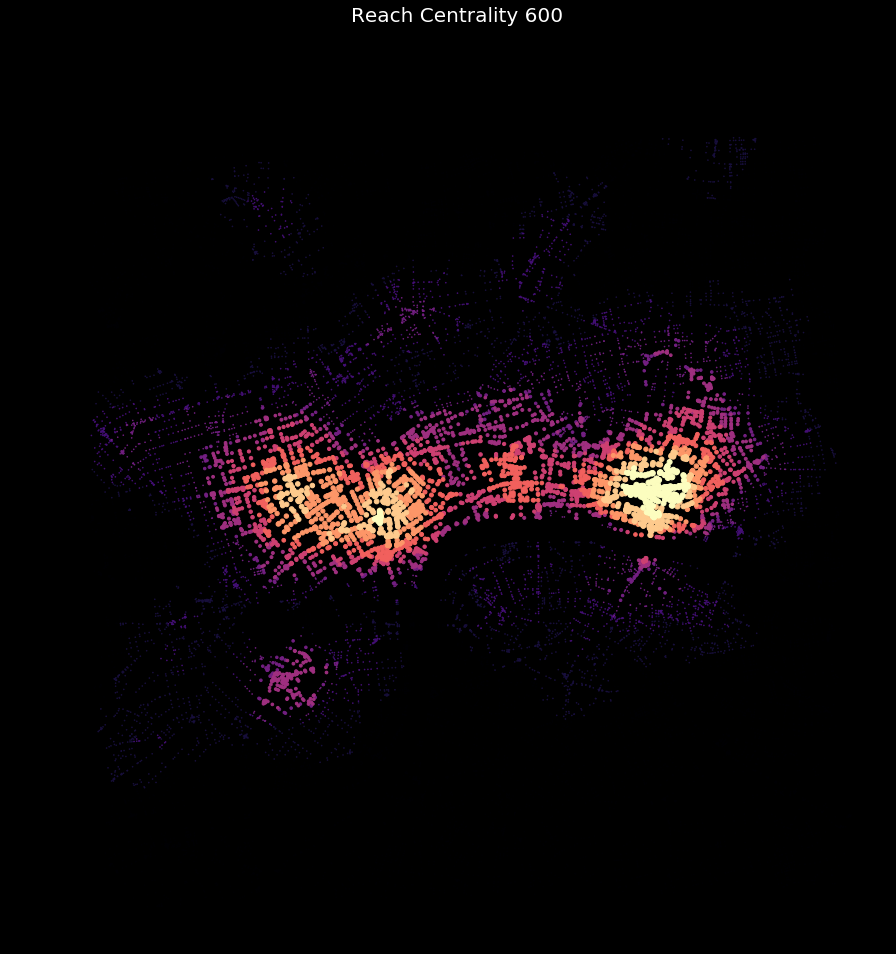

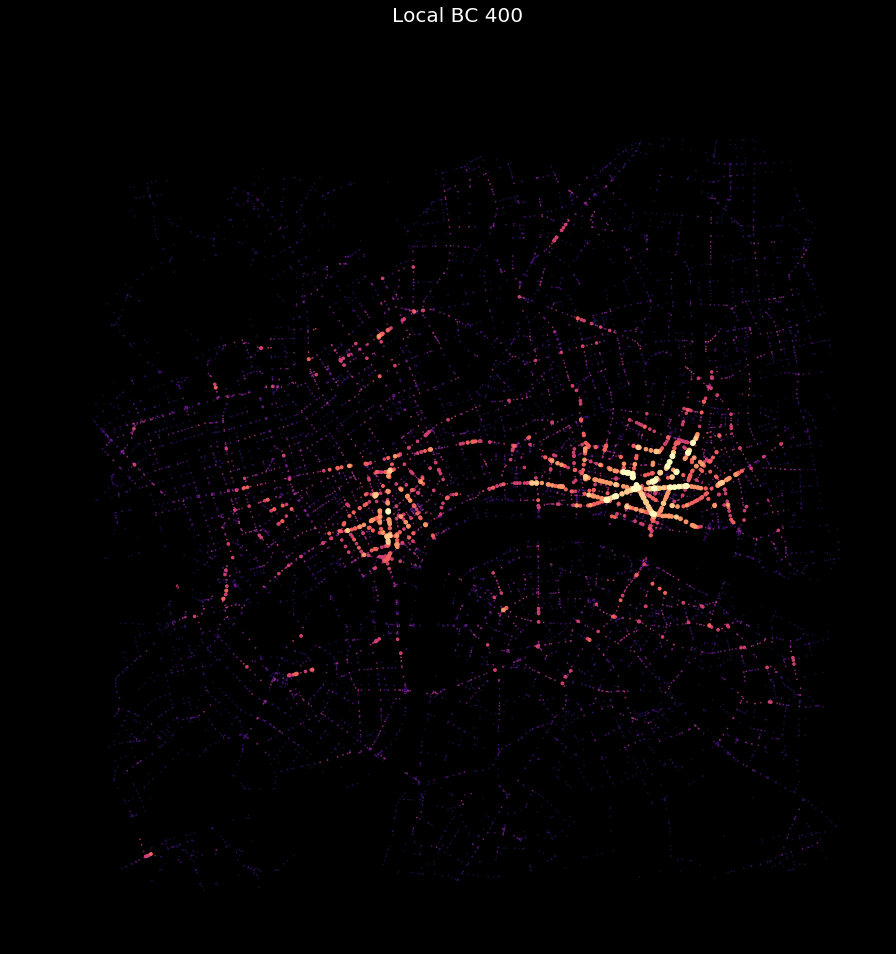

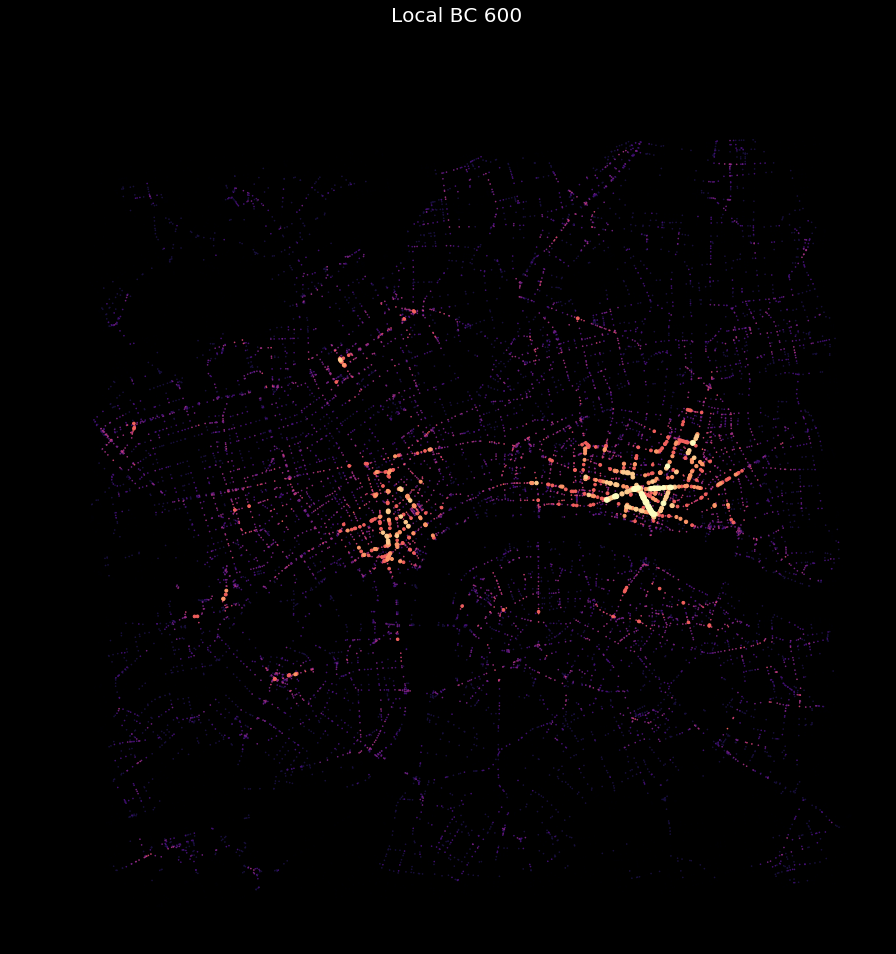

In [22]:
# visualising by passing a series of markersize values (ms) - indicate the column

col = ['Bc', 'Rc400', 'Rc600', 'Bc400', 'Bc600']
title = ['Betweennes Centrality', 'Reach Centrality 400', 'Reach Centrality 600', 'Local BC 400', 'Local BC 600']

for n, i in enumerate(col):
    uf.scaling_columnDF(nodes, i)
    tmp = nodes.copy()
    tmp['ms'] = np.where(tmp[i+'_sc'] >= 0.20, tmp[i+'_sc']*32, 0.40)
    uf.plot_points(tmp, column = i, classes = 10, ms_col = 'ms', title = title[n], cmap = 'magma', f = 15)

### Saving the area of interest for external uses (e.g. simulation)

In [ ]:
"""
The geodataframes obtained above are clipped from the area of interest. 
This process may cause the network to be not cleaned again. 
The cleaning functions are run again prior to the extraction the dual network (see below for measures in the Dual Graph).
"""
clipping = False
if clipping == True:
    buffer = polygon_clip.geometry.loc[0].buffer(100)
    nodes_clipped = nodes[nodes.geometry.within(buffer)]
    edges_clipped = edges_small[edges_small.geometry.within(buffer)]
    nodes_clipped, edges_clipped = snf.clean_network(nodes_clipped, edges_clipped, dead_ends = True)
    nodes_clipped, edges_clipped = snf.reset_index_gdf(nodes_clipped, edges_clipped)
    nodes_clipped, edges_clipped = snf.correct_edges(nodes_clipped, edges_clipped)
    nodesDual_clipped, edgesDual_clipped = snf.dual_gdf(nodes_clipped, edges_clipped, crs)

    col = ['Bc', 'Rc400', 'Rc600', 'Bc400', 'Bc600']
    for i in col: uf.scaling_columnDF(nodes_clipped, i)
    col = ['length']
    for i in col: uf.scaling_columnDF(edges_clipped, i)
    col = ['deg', 'rad']
    for i in col: uf.scaling_columnDF(edgesDual_clipped, i)
    
    nodes_clipped['height'] = 2 # this will be used for 3d visibility analysis
    nodes_clipped.crs = crs
    nodes_clipped.to_file(folder_ouptut+city_name+'_nodes.shp', driver ='ESRI Shapefile')
    edges_clipped.crs = crs
    edges_clipped.to_file(folder_ouptut+city_name+'_paths.shp', driver ='ESRI Shapefile')

    nodesDual_clipped = nodesDual_clipped.drop('intersecting', axis=1)
    nodesDual_clipped.crs = crs
    nodesDual_clipped.to_file(folder_ouptut+city_name+'_nodesDual.shp', driver = 'ESRI Shapefile')
    edgesDual_clipped.crs = crs
    edgesDual_clipped.to_file(folder_ouptut+city_name+'_edgesDual.shp', driver = 'ESRI Shapefile')
    
else:
    nodesDual, edgesDual = snf.dual_gdf(nodes_small, edges_small, crs)

    col = ['length']
    for i in col: uf.scaling_columnDF(edges_small, i)
    nodes_small['height'] = 2 # this will be used for 3d visibility analysis
    nodes_small.crs = crs
    nodes_small.to_file(folder_ouptut+city_name+'_nodes.shp', driver ='ESRI Shapefile')
    edges_small.crs = crs
    edges_small.to_file(folder_ouptut+city_name+'_paths.shp', driver ='ESRI Shapefile')
    
    col = ['deg']
    for i in col: uf.scaling_columnDF(edgesDual, i)

    nodesDual = nodesDual.drop('intersecting', axis=1)
    nodesDual.crs = crs
    nodesDual.to_file(folder_ouptut+city_name+'_nodesDual.shp', driver = 'ESRI Shapefile')
    edgesDual.crs = crs
    edgesDual.to_file(folder_ouptut+city_name+'_edgesDual.shp', driver = 'ESRI Shapefile')
    

In [41]:
dd_u = dict(edges_small['u'].value_counts())
dd_v = dict(edges_small['v'].value_counts())
dd = {k: dd_u.get(k, 0) + dd_v.get(k, 0) for k in set(dd_u) | set(dd_v)}
to_delete = {k: v for k, v in dd.items() if v == 1}
len(to_delete)

0

## Paths

On the primal graph representation of the street network, the following centrality measures are computed on edges:
* Euclidean Betweenness centrality.
* Information Betweenness centrality.
On the dual graph representation of the street network:
* Angular Betweenness centrality.

The third measure (*Ab*) is here used to identify Lynchian paths.

In [23]:
# Euclidean betweenness centrality
Eb = nx.edge_betweenness_centrality(NGs, weight = 'length', normalized = False)

In [24]:
# # Information centrality
# Erw = nx.edge_current_flow_betweenness_centrality(NGs, weight= 'length', normalized=False)
# # reordering elements
# for k, v in Erw.items():
#     if k[0] > k[1]: Erw[(k[1], k[0])] = Erw.pop((k[0], k[1]))

In [30]:
# creating geodataframe
edgesID = {}
for i, g in NGs.edges(): edgesID[(i,g)] = NGs[i][g]['streetID']

col = [Eb, edgesID]
names = ['Eb', 'streetID']

edges_df = uf.dict_to_df(col, names)
edges_df.streetID = edges_df.streetID.astype(int)
edges_tmp = pd.merge(edges_small, edges_df, left_on = 'streetID', right_on = 'streetID', how = 'left')

In [53]:
edges_small.to_file(folder_ouptut+city_name+'_ver.shp', driver ='ESRI Shapefile')

In [57]:
edges_small[edges_small.streetID.isin(t)]

streetID  key                                           geometry  \
10163     10163    1  LINESTRING (534427.4991929951 180111.451134334...   
13992     13992    1  LINESTRING (530410.003965219 178462.9659548188...   
29453     29453    1  LINESTRING (531020.2912216093 180824.334960546...   
33590     33590    1  LINESTRING (531907.3253046413 180261.456929395...   
36997     36997    1  LINESTRING (531110.1349615125 183101.664410217...   
39053     39053    1  LINESTRING (531358.5132628519 182689.455170704...   
40395     40395    1  LINESTRING (528570.2969201409 184150.655530924...   
41092     41092    1  LINESTRING (531131.9020744162 179905.615733391...   
41774     41774    1  LINESTRING (528783.0469960484 179192.000513627...   
45366     45366    1  LINESTRING (528664.0572021223 184254.836924476...   
45682     45682    1  LINESTRING (531488.7417122726 183859.720173800...   
46736     46736    1  LINESTRING (529985.8190448303 181273.656511059...   
49593     49593    1  LINESTRING (530189.0415322179 183098.043522824...   
53287     53287    1  LINESTRING (531880.1536024751 183273.797162381...   
58454     58454    1  LINESTRING (528900.4144748974 181032.916417792...   
70563     70563    1  LINESTRING (531382.2343606803 184398.987867824...   
76380     76380    1  LINESTRING (527154.3492868583 182846.347450903...   
86257     86257    1  LINESTRING (531116.7813211994 184246.640006455...   

       length       highway  oneway               name      u      v  \
10163  57.672       footway       0                NaN   3728  26833   
13992  43.716       footway       0                NaN  23461  23460   
29453  65.762       footway       0                NaN  10862  10859   
33590  91.192  unclassified       0      Sumner Street  19842  24247   
36997 122.041         trunk       0   Pentonville Road  17861  27539   
39053  32.700      tertiary       0    Hardwick Street  14396  23293   
40395  29.467       service       0                NaN  14917  30636   
41092  44.255       footway       0                NaN  15180  28787   
41774 124.852         trunk       0  Grosvenor Gardens  15419  17869   
45366  94.645       footway       0                NaN  17868  16747   
45682  20.207       footway       0                NaN  16861  16864   
46736  22.858       footway       0                NaN  30188  17254   
49593  26.937       footway       0                NaN  18272  24569   
53287  34.241  unclassified       0     Danbury Street  19631  20141   
58454  21.489  unclassified       0     Hanover Square  21410  22717   
70563  75.684       footway       0                NaN  26702  26699   
76380  45.488       footway       0                NaN  27999  28030   
86257  10.559       footway       0                NaN  31723  31724   

       pedestrian  
10163           1  
13992           1  
29453           1  
33590           0  
36997           0  
39053           0  
40395           1  
41092           1  
41774           1  
45366           1  
45682           1  
46736           1  
49593           1  
53287           0  
58454           0  
70563           1  
76380           1  
86257           1

In [56]:
t = list(set(edges_small.streetID.tolist()) - set(v))

In [46]:
for i, g in NGs.edges(): 
    v.append(NGs[i][g]['streetID'])

C:\Users\g_filo01\AppData\Local\Continuum\anaconda3\lib\site-packages\mapclassify\classifiers.py:276: RuntimeWarning: invalid value encountered in greater
  binIds += (x > l) * (x <= r) * k
C:\Users\g_filo01\AppData\Local\Continuum\anaconda3\lib\site-packages\mapclassify\classifiers.py:276: RuntimeWarning: invalid value encountered in less_equal
  binIds += (x > l) * (x <= r) * k
C:\Users\g_filo01\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


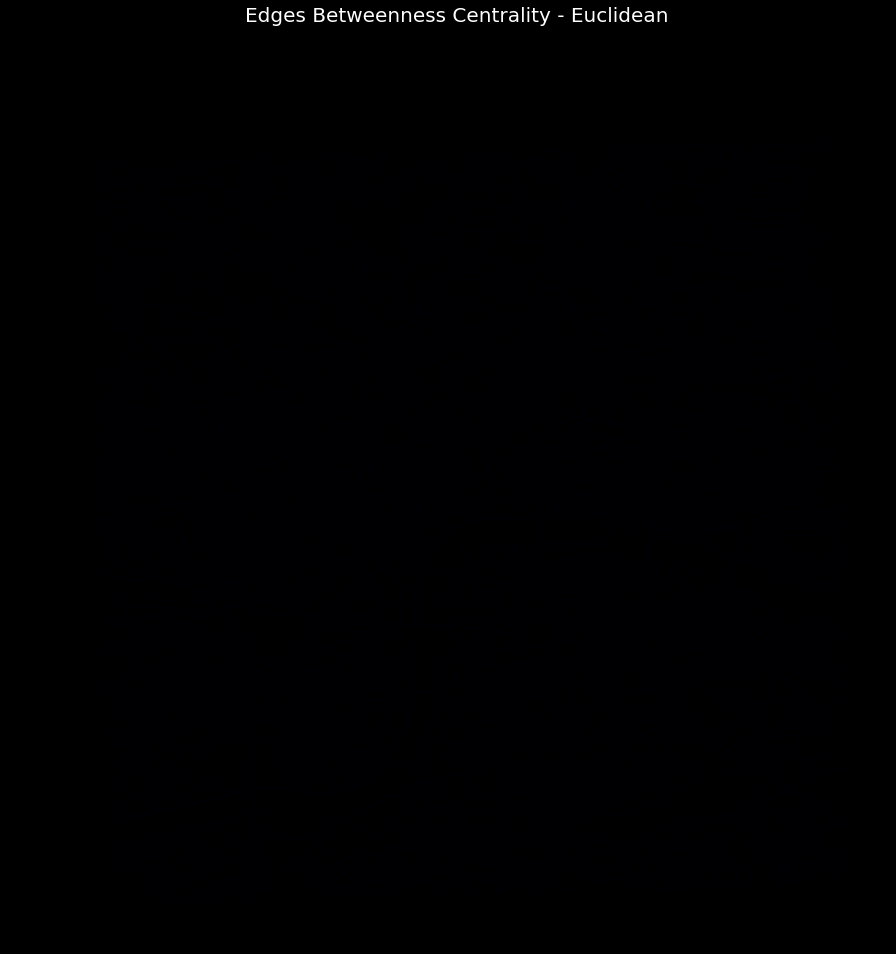

In [35]:
# visualising
uf.plot_lines(edges_tmp, classes = 8, column = 'Eb', title = 'Edges Betweenness Centrality - Euclidean', lw = 1.9, 
              scheme = 'fisher_jenks', cmap = 'magma', f =15)
# uf.plot_lines(edges_tmp, classes = 8, column = 'Erw', title = 'Edges Information Centrality', lw = 1.9,
#             scheme = 'fisher_jenks', cmap = 'magma', f =15)

## Dual graph analysis

Here street-segments are transformed into nodes (geograpically represented by their centroids). Fictional links represent instead intersections. Thus if two segments are connected in the actual street network, a link in the dual graph representation will be created by connecting the corresponding nodes. 
This process allows to take advantage of angular relationships in centrality measures computation and other network techniques.

In [96]:
# creating the dual geodataframes. The angle of incidence is computed at this stage, between each pair of street-segments.
nodesDual_small, edgesDual_small = snf.dual_gdf(nodes_small, edges_small, crs)
# nodesDual_large, edgesDual_large = snf.dual_gdf(nodes_large, edges_large, crs)

Wall time: 6min 59s


## Creating the dual graph

In [ ]:
"""
Creating the dual graph
"""

DG_small = snf.get_dual_graph(nodesDual_small, edgesDual_small)

## Angular Betweenness - Paths

In [ ]:
# Angular-change betweenness centrality
Ab = nx.betweenness_centrality(DG_small, weight = 'rad', normalized = False)
Ab_dict = snf.dual_id_dict(Ab, DG_small, 'streetID')
Ab_df = uf.dict_to_df([Ab_dict], ['Ab'])
edges = pd.merge(edges_tmp, Ab_df, left_on = "streetID", right_index = True, how='left')

In [ ]:
uf.plot_lines(edges, column = 'Ab', title = 'Edges Betweenness Centrality - Angular Change', lw = 1.9, cmap = 'magma', 
              scheme = 'fisher_jenks',f = 15)

## Districts

Finally, districts are extracted using the Modularity Optimisation Algorithm.

In [ ]:
# specify which graph shall be used for the district identification
if option_1 == True: 
    nodes_large, edges_large = nodes_small, edges_small
    DG_large = DG_small
else: DG_large =  snf.get_dual_graph(nodesDual_large, edgesDual_large)

In [157]:
"""
different weights are used to extract the partitions;
 'False' indicates that no weights will be used (only topological relationships will matter)
"""
weights = ['length', 'rad', 'False']
subdvisions = []

# extraction of the best partitions
for i in weights:
    partition = community.best_partition(DG_large, weight=i)
    dct = snf.dual_id_dict(partition, DG_large, 'streetID')
    subdvisions.append(dct)

# saving the data in a geodataframe
partitions_df = uf.dict_to_df(subdvisions, ["p_len", "p_rad", 'p_no'])
districts = pd.merge(edges_large, partitions_df, left_on = "streetID", right_index = True, how= 'left')

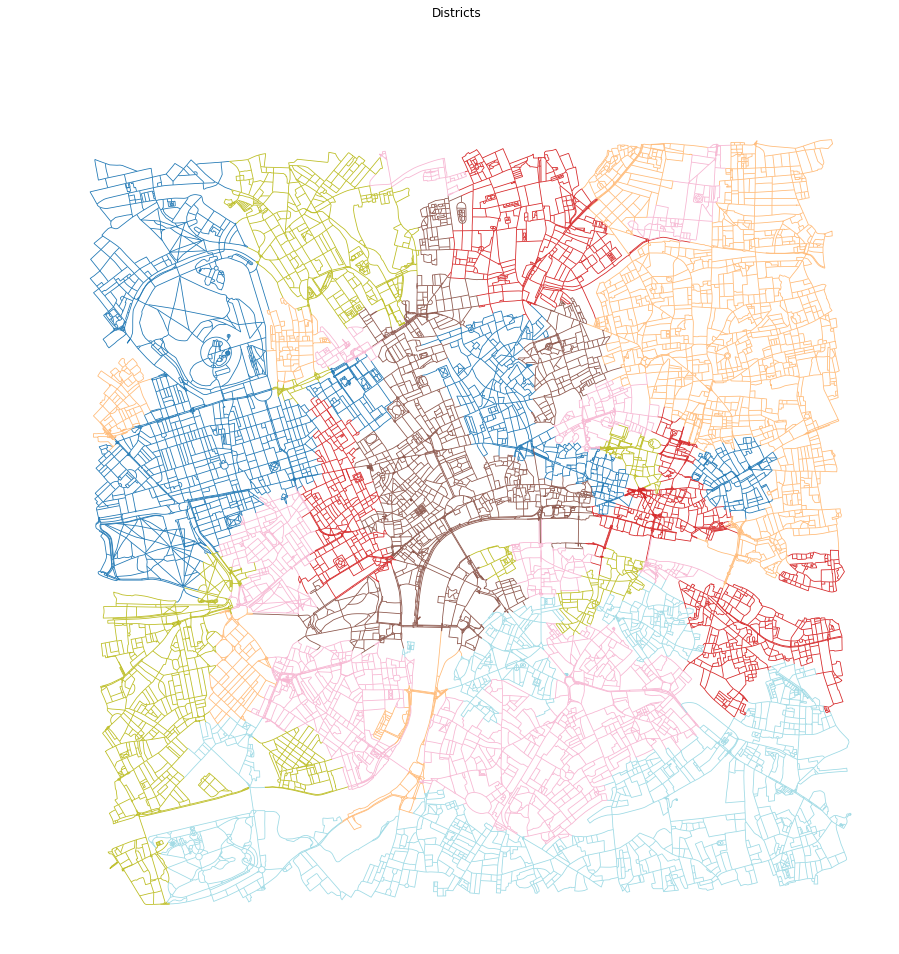

In [227]:
# visualising
uf.plot_lines(districts, column = 'p_rad', title = 'Districts', lw = 0.8, cmap = 'tab20', bb = False, legend = False, f =15)

## Natural Roads

Finally, before saving, street segments are categorised based on the continuing roads or natural roads approach.
Streets are indeed recognised as entities by an observer in relation to the perception of continuity - a concept adressed already by Lynch himself - rather than for their name.
Continuity is based indeed on the degree of angular change.

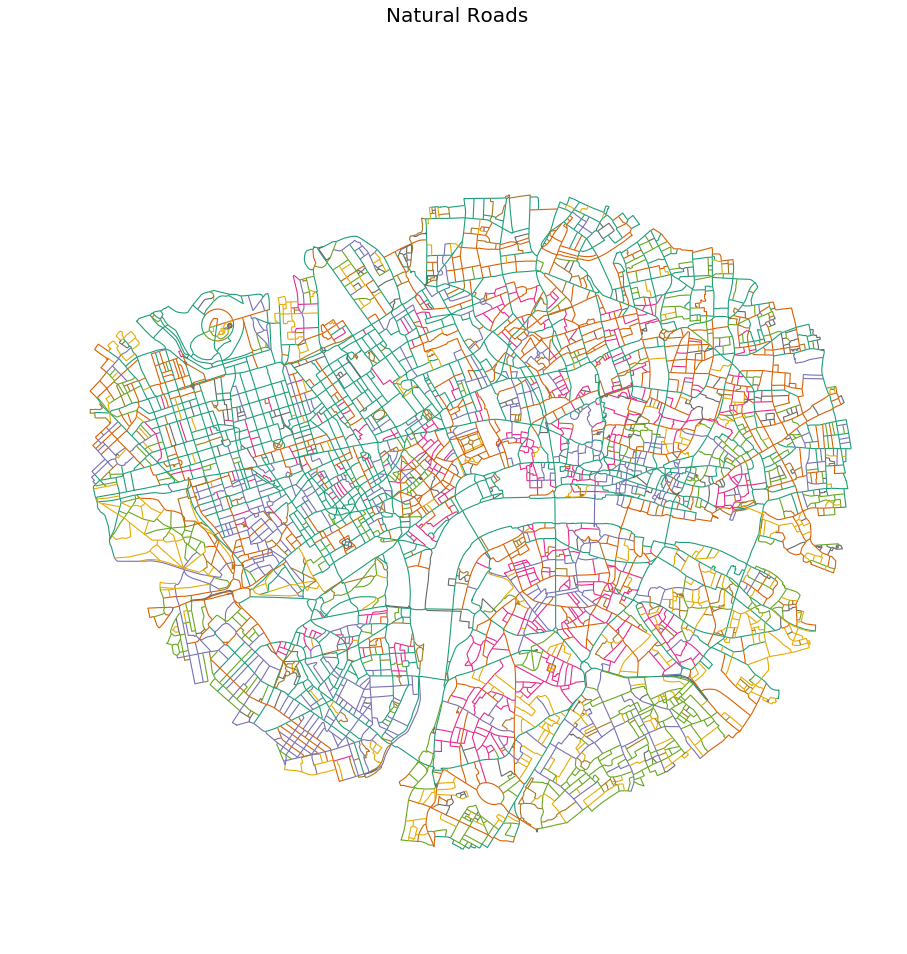

Wall time: 848 ms


In [107]:
%%time
reload(snf)
# running natural roads_functions and visualising
snf.run_natural_roads(nodes, edges)
uf.plot_lines(edges, column = 'naturalID', title = 'Natural Roads', 
              lw = 1.1, cmap = 'Dark2', bb = False, legend = False, f = 15)

## Saving Large network

In [269]:
# saving the large networks

nodes.crs = crs
nodes.to_file(folder_ouptut+'large_network/'+city_name+'_nodes.shp', driver='ESRI Shapefile')
edges.crs = crs
edges.to_file(folder_ouptut+'large_network/'+city_name+'_paths.shp', driver ='ESRI Shapefile')

nodesDual_small = nodesDual_small.drop('intersecting', axis=1)
nodesDual_small.crs = crs
nodesDual_small.to_file(folder_ouptut+'large_network/'+city_name+'_nodesDual.shp', driver = 'ESRI Shapefile')
edgesDual_small.crs = crs
edgesDual_small.to_file(folder_ouptut+'large_network/'+city_name+'_edgesDual.shp', driver = 'ESRI Shapefile')

In [272]:
# saving districts
districts.crs = crs
districts.to_file(folder_ouptut+city_name+'_paths.shp', driver = 'ESRI Shapefile')